In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.text import *

In [3]:
PATH = Path('data/IAM_handwriting')
TMP_PATH = PATH/'tmp'
CSV = PATH/'words.csv'

# !ls {PATH}

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prelim

### Manual DataFrame

In [5]:
maxTextLen = 32
samples = []
chars = set()

f=open(f'{PATH}/ascii/words.txt')
for line in f:
    # ignore comment line
    if not line or line[0]=='#':
        continue

    lineSplit = line.strip().split(' ')
    assert len(lineSplit) >= 9

    fileName = lineSplit[0]

    # GT text are columns starting at 9
    gtText = ''.join(lineSplit[8:])[:maxTextLen]
    char_len = len(gtText)
    chars = chars.union(set(list(gtText)))

    # put sample into list
    samples.append([fileName, gtText, char_len])
    
data = np.stack(samples)
df = pd.DataFrame(data, columns=['filename', 'word', 'char_len'], )

In [6]:
df['char_len'] = df.char_len.astype('int32')
df = df.loc[df['char_len'] > 3]
df.head()

,filename,word,char_len
1,a01-000u-00-01,MOVE,4
3,a01-000u-00-03,stop,4
5,a01-000u-00-05,Gaitskell,9
6,a01-000u-00-06,from,4
7,a01-000u-01-00,nominating,10


### Numericalize characters

In [7]:
itos = sorted(list(chars))
itos.insert(0, '_pad_')
itos.insert(1, ' ')
itos.insert(2, '_unk_')
itos.insert(3, '_eos_')
len(itos)

82

In [8]:
joined_labels = list(df.word)

stoi = collections.defaultdict(lambda: 2, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([stoi[letter] for letter in word] + [3]) for word in joined_labels])

In [9]:
# convert to strings (as labels)
str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)

In [10]:
df['char_ids'] = str_ids
df.head()

,filename,word,char_len,char_ids
1,a01-000u-00-01,MOVE,4,42 44 51 34 3
3,a01-000u-00-03,stop,4,74 75 70 71 3
5,a01-000u-00-05,Gaitskell,9,36 56 64 75 74 66 60 67 67 3
6,a01-000u-00-06,from,4,61 73 70 68 3
7,a01-000u-01-00,nominating,10,69 70 68 64 69 56 75 64 69 62 3


In [11]:
pickle.dump(itos, open(TMP_PATH/'char_itos.pkl', 'wb'))

In [12]:
df.to_csv(CSV, columns=['filename', 'char_ids'], index=False)

# Helper Functions

In [5]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = np.trim_zeros(ints)   # remove padding (0)
    return ''.join([itos[i] for i in ints])

In [6]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    if title: ax.set_title(title)
    return ax

# Data

In [7]:
itos = pickle.load(open(TMP_PATH/'char_itos.pkl', 'rb'))

#### Full ~57,000

In [8]:
csv = pd.read_csv(CSV)
csv.head()

,filename,char_ids
0,a01-000u-00-01,42 44 51 34 3
1,a01-000u-00-03,74 75 70 71 3
2,a01-000u-00-05,36 56 64 75 74 66 60 67 67 3
3,a01-000u-00-06,61 73 70 68 3
4,a01-000u-01-00,69 70 68 64 69 56 75 64 69 62 3


#### Sample ~5,000

In [7]:
CSV = PATH/'sample_words.csv'

# samp = csv.sample(5000).reset_index(drop=True)
# samp.to_csv(CSV, index=False)

csv = pd.read_csv(CSV)
csv.head()

,filename,char_ids
0,h07-063b-00-02,71 73 60 68 64 74 60 74 3
1,n04-000-02-06,57 60 75 75 60 73 3
2,n06-123-04-08,59 70 78 69 3
3,g06-011c-01-07,60 69 65 70 80 60 59 3
4,j06-005-00-01,68 64 62 73 56 75 64 69 62 3


### Get val_idxs

In [10]:
val_idxs = np.array(csv.sample(frac=0.15).index)
len(val_idxs)

8633

### ModelData object

In [11]:
f = resnet34
sz = 64
bs = 100

In [32]:
aug_tfms = [RandomRotate(3, mode=1), RandomLighting(0.05, 0.05)]

tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
data = ImageClassifierData.from_csv(PATH, 'words', CSV, bs=bs, val_idxs=val_idxs, 
                                    suffix='.png', tfms=tfms, continuous=True)

In [33]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

### Verify dataset transforms

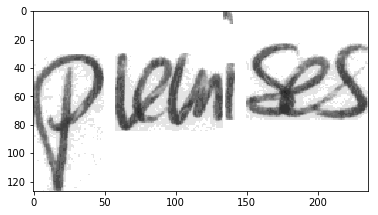

In [17]:
im = Image.open(PATH/'words'/'h07-063b-00-02.png')
plt.imshow(im)

In [14]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
x = denorm(x)

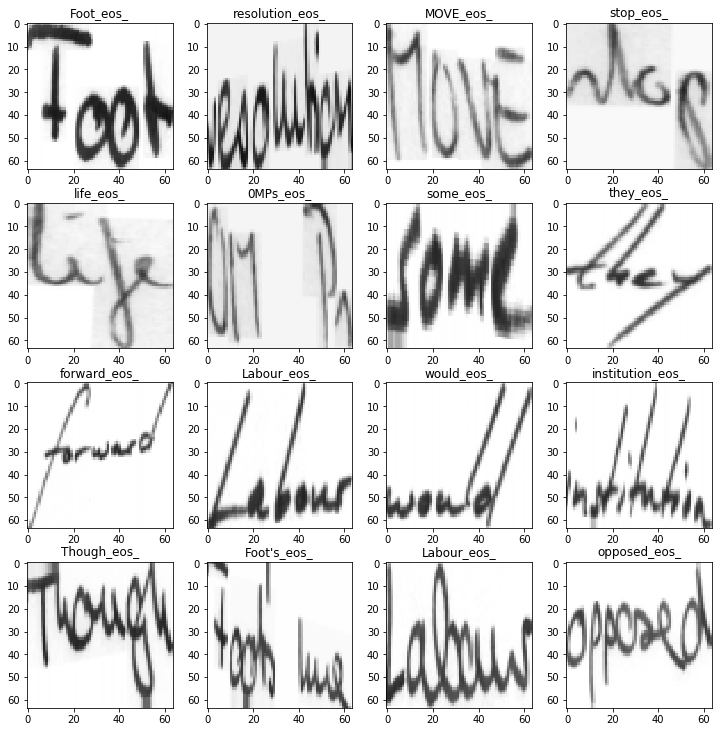

In [15]:
fig, axes = plt.subplots(4,4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i])
    ax=show_img(x[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

# Loss and Metrics

In [16]:
# categorical cross entropy loss
# list of probabilities for each word in vocab; target is correct word

def seq2seq_loss(input, target):
    target = target.permute(1,0).contiguous()
    tsl = target.size(0)
    sl,bs,nc = input.size()
    
    if sl>tsl: target = F.pad(target, (0,0,0,sl-tsl))
    if tsl>sl: target = target[:sl]
        
    targ = target.view(-1)
    pred = input.view(-1, nc)

    # combination of LogSoftmax and NLLLoss
    return F.cross_entropy(pred, targ.long(), reduction='sum')/bs

In [17]:
import Levenshtein as Lev

# pulled from Sean Nareen's deepspeech decoder module
# https://github.com/SeanNaren/deepspeech.pytorch/blob/master/decoder.py

def cer(t, p):
    """
    Computes the Character Error Rate, defined as the edit distance.
    Arguments:
        t (string): target space-separated sentence
        p (string): prediction space-separated sentence
    """
    t, p, = t.replace(' ', ''), p.replace(' ', '')
    return Lev.distance(t, p)/len(t)

def wer(s1, s2):
    """
    Computes the Word Error Rate, defined as the edit distance between the
    two provided sentences after tokenizing to words.
    Arguments:
        s1 (string): space-separated sentence
        s2 (string): space-separated sentence
    """

    # build mapping of words to integers
    b = set(s1.split() + s2.split())
    word2char = dict(zip(b, range(len(b))))

    # map the words to a char array (Levenshtein packages only accepts
    # strings)
    w1 = [chr(word2char[w]) for w in s1.split()]
    w2 = [chr(word2char[w]) for w in s2.split()]

    return Lev.distance(''.join(w1), ''.join(w2))

In [18]:
def error_label(pred):
    ints = to_np(pred).astype(int)
    ints = ints[np.nonzero(ints)]
    return ''.join([itos[i] for i in ints])

def char_error_rate(preds, targs):
    bs,sl = targs.size()      #=> ([bs, sl])
    # preds.size()            #=> ([sl, bs, vs])
        
    res = torch.argmax(preds, dim=2)
    error = 0
    for i in range(bs):
        p = error_label(res[:,i])
        t = error_label(targs[i])
        error += cer(t,p)
    return error/bs

# Arch

In [18]:
class Encoder(nn.Module):
    def __init__(self, embed_size, drop=0.4):
        super().__init__()
        
        slices = {128: -4, 256: -3, 512: -2}
        s = slices[embed_size]
        
        net = f(True)
        modules = list(net.children())[:s]    #(8,8,256)  sz: 128
        self.base = nn.Sequential(*modules)
        
        #mlp
        self.drop = nn.Dropout(drop)
        self.linear1 = nn.Linear(embed_size, embed_size)
        self.linear2 = nn.Linear(embed_size, embed_size)
        
    def forward(self, inp):
        bs,nf,h,w = inp.size()
        
        features = self.base(inp)
        features = features.flatten(2, 3).permute(2, 0, 1)
        
        # initial hidden is an average of features fed through an MLP
        h = self.drop(features)
        h = self.linear2(F.relu(self.linear1(h))).mean(0)
                        
        return features, h

In [19]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Attention(nn.Module):
    def __init__(self, embed_size, drop=0.1):
        super().__init__()

        self.attn_1 = nn.Linear(embed_size, embed_size)
        self.attn_2 = nn.Linear(embed_size, embed_size)
        self.drop   = nn.Dropout(drop)
        self.attn_v = rand_p(embed_size)
        
    def forward(self, hidden, feats):
        # this is called once for each timestep
        w1e = self.attn_1(feats)                    # ([64, 30, 256])
        w2h = self.attn_2(hidden)                   # ([30, 256])
        u = torch.tanh(w1e + w2h)                   # ([64, 30, 256])
        u = self.drop(u)
        a = torch.softmax(u @ self.attn_v, 0)       # ([64, 30]) - attention mask
        context = (a.unsqueeze(2) * feats).sum(0)   # ([30, 256]) - weighted sum of features w/ attention
        
        return context, a

In [20]:
class RNNDecoder(nn.Module):
    def __init__(self, embed_size, num_layers, drop=0.3):
        super().__init__()
        
        self.num_layers = num_layers
        self.rnn = nn.GRU(embed_size, embed_size, num_layers)
        if self.num_layers > 1: self.rnn.dropout = drop

    def forward(self, hidden, context):
        _, h = self.rnn(context.unsqueeze(0), hidden.expand(self.num_layers, -1, -1).contiguous())
        
        return h[-1]

In [21]:
class DeepOutputLayer(nn.Module):
    def __init__(self, embed_size, vocab_size, drop=0.3):
        super().__init__()
        
        self.w0 = nn.Linear(embed_size, embed_size)
        self.w1 = nn.Linear(embed_size, embed_size)
        self.w2 = nn.Linear(embed_size, embed_size)
        self.w3 = nn.Linear(embed_size*3, vocab_size)
        self.drop = nn.Dropout(drop)
        
    def forward(self, prev, hidden, context):
        # this is called once for each timestep
        #(30,256)
        a = self.w0(prev)
        b = self.w1(hidden)
        c = self.w2(context)
        out = torch.cat([a,b,c], 1)
        
        return self.w3(self.drop(out))

In [25]:
class Net(nn.Module):
    def __init__(self, hidden_size, vocab_size, seq_len, n_layers=1, drop=0.2):
        super(Net, self).__init__()
        self.seq_len = seq_len
        
        self.encoder = Encoder(hidden_size)
        self.attention = Attention(hidden_size)
        self.decoder = RNNDecoder(hidden_size, n_layers)
        
        self.embed   = nn.Embedding(vocab_size, hidden_size)
        self.drop    = nn.Dropout(drop)
        self.embed.weight.data.uniform_(-0.1, 0.1)

        self.output  = DeepOutputLayer(hidden_size, vocab_size)
        
    def forward(self, x, ret_attn=False):
        bs = x.size(0)
        feats, hidden = self.encoder(x)
        
        res,attns = [],[]
        dec_inp = torch.ones(bs, device=device).long()
        
        for i in range(self.seq_len):
            prev = self.drop(self.embed(dec_inp))
            
            context, a = self.attention(hidden, feats)
            hidden = self.decoder(hidden, context)
            out = self.output(prev, hidden, context)
            
            res.append(out)
            attns.append(a)
            dec_inp = out.data.max(1)[1]
            
        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

In [26]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Net(256, len(itos), 20, 1)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [char_error_rate]

# Arch modifications - annotated transformer, im2latex

In [41]:
class Encoder(nn.Module):
    def __init__(self, embed_size, drop=0.2):
        super().__init__()
        
        slices = {128: -4, 256: -3, 512: -2}
        s = slices[embed_size]
        
        net = f(True)
        modules = list(net.children())[:s]    #(8,8,256)  sz: 128
        self.base = nn.Sequential(*modules)
        
        #pos_enc
        self.pos_enc = PositionalEncoding(embed_size, drop)
        
        #mlp
        self.linear1 = nn.Linear(embed_size, embed_size)
        self.linear2 = nn.Linear(embed_size, embed_size)
        self.drop = nn.Dropout(drop)
        
    def forward(self, inp):
        bs,nf,h,w = inp.size()
        
        features = self.base(inp)
        features = features.flatten(2, 3).permute(2, 0, 1)
        features = self.pos_enc(features)
        
        # initial hidden is an average of features fed through an MLP
        h = F.leaky_relu(self.linear1(features.mean(0)))
        h = self.linear2(self.drop(h))
        
        # mean of features run through linear layer
#         h = torch.tanh(self.linear1(h.mean(0)))
                        
        return features, h

In [40]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, embed_size, dropout, max_len=500):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, embed_size)
        position = torch.arange(0.0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0.0, embed_size, 2) * -(math.log(10000.0) / embed_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:x.size(0)], requires_grad=False)    # ([sl, 1, 256])
        return self.dropout(x)

In [21]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Attention(nn.Module):
    def __init__(self, embed_size, drop=0.1):
        super().__init__()

        self.attn_1 = nn.Linear(embed_size, embed_size)
        self.attn_2 = nn.Linear(embed_size, embed_size)
        self.drop   = nn.Dropout(drop)
        self.attn_v = rand_p(embed_size)
        
    def forward(self, hidden, feats):
        w1e = self.attn_1(feats)                    # ([64, 30, 256])
        w2h = self.attn_2(hidden)                   # ([30, 256])
        u = torch.tanh(w1e + w2h)                   # ([64, 30, 256])
        u = self.drop(u)
        a = torch.softmax(u @ self.attn_v, 0)       # ([64, 30]) - attention mask
        context = (a.unsqueeze(2) * feats).sum(0)   # ([30, 256]) - weighted sum of features w/ attention
        
        return context, a

In [22]:
class RNNDecoder(nn.Module):
    def __init__(self, embed_size, num_layers, drop=0.3):
        super().__init__()
        
        self.num_layers = num_layers
        self.rnn = nn.GRU(embed_size, embed_size, num_layers)
        if self.num_layers > 1: self.rnn.dropout = drop

    def forward(self, hidden, context):
        _, h = self.rnn(context.unsqueeze(0), hidden.expand(self.num_layers, -1, -1).contiguous())
        
        return h[-1]

In [23]:
class DeepOutputLayer(nn.Module):
    def __init__(self, embed_size, vocab_size, drop=0.3):
        super().__init__()
        
        self.l1 = nn.Linear(embed_size*3, embed_size)
        self.l2 = nn.Linear(embed_size, vocab_size)
#         self.w0 = nn.Linear(embed_size, embed_size)
#         self.w1 = nn.Linear(embed_size, embed_size)
#         self.w2 = nn.Linear(embed_size, embed_size)
#         self.w3 = nn.Linear(embed_size*3, vocab_size)
        self.drop = nn.Dropout(drop)
        
    def forward(self, prev, hidden, context):
        # this is called once for each timestep
        #(30,256)
#         a = self.w0(prev)
#         b = self.w1(hidden)
#         c = self.w2(context)
#         out = torch.cat([a,b,c], 1)
#         out = self.w3(self.drop(out))
        out = self.l1(torch.cat([prev,hidden,context], -1))
        out = self.l2(self.drop(F.leaky_relu(out)))
        return out

In [24]:
class Embedding(nn.Module):
    def __init__(self, vocab, d_model, drop=0.2):
        super(Embedding, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        emb = self.lut(x) * math.sqrt(self.d_model)
        return self.drop(emb)

In [42]:
class Net(nn.Module):
    def __init__(self, hidden_size, vocab_size, seq_len, n_layers=1):
        super(Net, self).__init__()
        self.seq_len = seq_len
        
        self.encoder = Encoder(hidden_size)
        self.attn    = Attention(hidden_size)
        self.decoder = RNNDecoder(hidden_size, n_layers)
        self.embed   = Embedding(vocab_size, hidden_size)
        self.output  = DeepOutputLayer(hidden_size, vocab_size)
        
    def forward(self, x, ret_attn=False):
        bs = x.size(0)
        feats, hidden = self.encoder(x)
        
        res,attns = [],[]
        dec_inp = torch.ones(bs, device=device).long()
        
        for i in range(self.seq_len):
            prev = self.embed(dec_inp)
            
            context, a = self.attn(hidden, feats)
            hidden = self.decoder(hidden, context)
            out = self.output(prev, hidden, context)
            
            res.append(out)
            attns.append(a)
            dec_inp = out.data.max(1)[1]
            
        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

In [43]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Net(256, len(itos), 20)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [char_error_rate]

In [159]:
lr=1e-3
# learn.fit(lr, 1, cycle_len=1)
# 55.378511  25.041582  0.447107

learn.fit(lr, 5, cycle_len=1, use_clr=(10,4))
# sample ~5000
# 21.156707  19.777774  0.523863    vanilla

# scan, attend, read modifications
# 21.623266  20.042625  0.557447    including 'location' attention (prev_attn.unsqueeze(2)*feats)
# 21.839842  20.125603  0.53964     including tanh layer in deepoutput

# im2latex modifications - https://guillaumegenthial.github.io/image-to-latex.html
# 21.77534   20.100386  0.554967    enc: add pos_enc to features (modified from annotated transformer)
# 21.374544  20.097782  0.57317     enc: "", feats.mean(0) prior to linear layer
# 22.104788  20.616136  0.544379    "", leaky_relu, Embedding (annotated transformer)

epoch      trn_loss   val_loss   char_error_rate          
    0      26.987927  22.325404  0.686034  
    1      24.624356  21.293182  0.466135                 
    2      23.801808  21.308162  0.453969                 
    3      22.630354  20.645247  0.513439                 
    4      22.104788  20.616136  0.544379                 


[20.616135597229004, 0.5443792303059426]

# Train

In [27]:
lr = 1e-3
learn.fit(lr, 1, cycle_len=1)
# 20.123179  19.649655  0.565135
# 21.393729  20.69109   0.579131      arch w/ modifications

epoch      trn_loss   val_loss   char_error_rate               
    0      21.393729  20.69109   0.579131  



[20.691089783591785, 0.5791305076677952]

In [29]:
learn.fit(lr, 5, cycle_len=1, use_clr=(10,4))
# 7.060167   7.557037   0.15504
# 3.876433   6.482149   0.112672  (2nd run)

# arch w/ modifications
# 14.264746  13.601401  0.39256
# 9.361735   9.57171    0.205794  (2nd run)

epoch      trn_loss   val_loss   char_error_rate            
    0      13.076419  12.264046  0.311696  
    1      11.833501  11.362987  0.275474                   
    2      10.905761  10.714036  0.25038                    
    3      10.214669  10.010741  0.223121                   
    4      9.361735   9.57171    0.205794                   



[9.57170955614112, 0.2057937581040192]

In [30]:
# learn.save('single-word-0.16cer')
# learn.save('single-word-0.11cer')
learn.save('single-mod-64')

In [61]:
# learn.load('single-word-0.11cer')
learn.load('single-mod-64')

## Increase size

In [31]:
sz = 128
bs = 80

In [34]:
learn.set_data(data)

In [64]:
lr = 1e-3
learn.fit(lr, 1, cycle_len=1)
# sz:128
# 5.724195   5.387444   0.10471
# 9.111385   8.19469    0.174504   # arch w/ mod

epoch      trn_loss   val_loss   char_error_rate             
    0      9.111385   8.19469    0.174504  



[8.194690457096806, 0.1745041084019705]

In [60]:
# learn.save('single-word-0.10cer')
learn.load('single-word-0.10cer')

In [68]:
learn.fit(lr, 5, cycle_len=1, use_clr=(10,4))
# sz: 128
# 2.893894   3.928638   0.068387
# 4.846448   5.301113   0.085465   # arch w/ mod

epoch      trn_loss   val_loss   char_error_rate             
    0      8.137693   7.099124   0.139303  
    1      6.986524   6.24214    0.111509                    
    2      5.853241   5.725533   0.097603                    
    3      5.523754   5.405436   0.090947                    
    4      4.846448   5.301113   0.085465                    



[5.301112763307713, 0.08546458826093556]

In [69]:
# learn.save('single-word-0.07cer')
# learn.load('single-word-0.07cer')
learn.save('single-mod-128')

## Increase size

In [30]:
sz = 256
bs = 50

In [68]:
learn.set_data(data)

In [69]:
lr = 1e-3
learn.fit(lr, 1, cycle_len=1)
# sz:128
# 5.724195   5.387444   0.10471

epoch      trn_loss   val_loss   char_error_rate             
    0      4.075548   4.024873   0.072837  


[4.024872808787175, 0.0728372694776557]

In [70]:
learn.save('256_1')

In [71]:
learn.fit(lr, 3, cycle_len=1, use_clr=(10,4))
# sz: 256
# 2.893894   3.928638   0.068387

learn.save('256_2')

epoch      trn_loss   val_loss   char_error_rate             
    0      3.771168   3.622963   0.064247  
    1      3.137131   3.466296   0.05971                     
    2      3.005676   3.312234   0.056752                    


# Results

In [34]:
learn.load('256_2')

In [70]:
x,y = next(iter(data.val_dl))
learn.model.eval()
preds,attns = learn.model(x, ret_attn=True)   #attns ([sl, 256, bs])
res = torch.argmax(preds, dim=-1)

seq2seq_loss(preds, y)

tensor(3.9220, device='cuda:0', grad_fn=<DivBackward0>)

In [71]:
char_error_rate(preds,y)

0.06863798004326253

In [39]:
for i in range(10):
    print(label_text(res[:,i]))

doon_eos_
with_eos_
time_eos_
dealt_eos_
question_eos_
that_eos_
month_eos_
fandy_eos_
giving_eos_
went_eos_


### Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


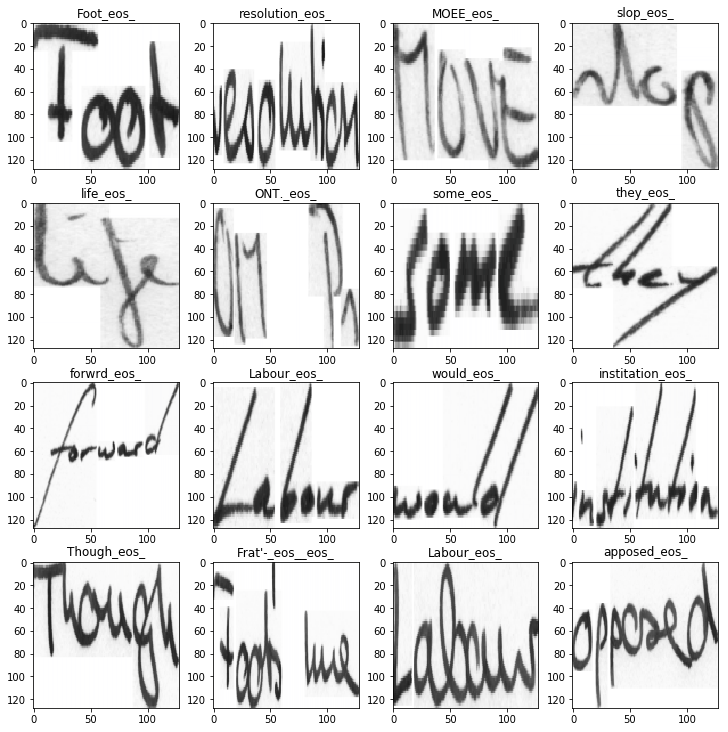

In [72]:
imgs = data.trn_ds.denorm(x)

fig, axes = plt.subplots(4,4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i])     #=>  char indices
    p = label_text(res[:,i])
    ax=show_img(imgs[i], ax=ax, title=p)#t+' '+p)
    
plt.tight_layout(pad=0.1)

### Attention

In [73]:
def torch_scale_attns(attns):
    sl,_,bs = attns.shape
    num = sz // 16
    mod = attns.permute(2,0,1).view(bs,sl,num,num)
    scaled = torch.nn.functional.interpolate(mod, size=sz)
    return scaled  #([bs, sl, sz, sz])

In [74]:
from scipy.ndimage import gaussian_filter

def g_filter(att, k=16):
    return gaussian_filter(att, sigma=k)

In [77]:
idx  = 11
img  = imgs[idx]
pred = res[:,idx]
img_attns = to_np(torch_scale_attns(attns)[idx])

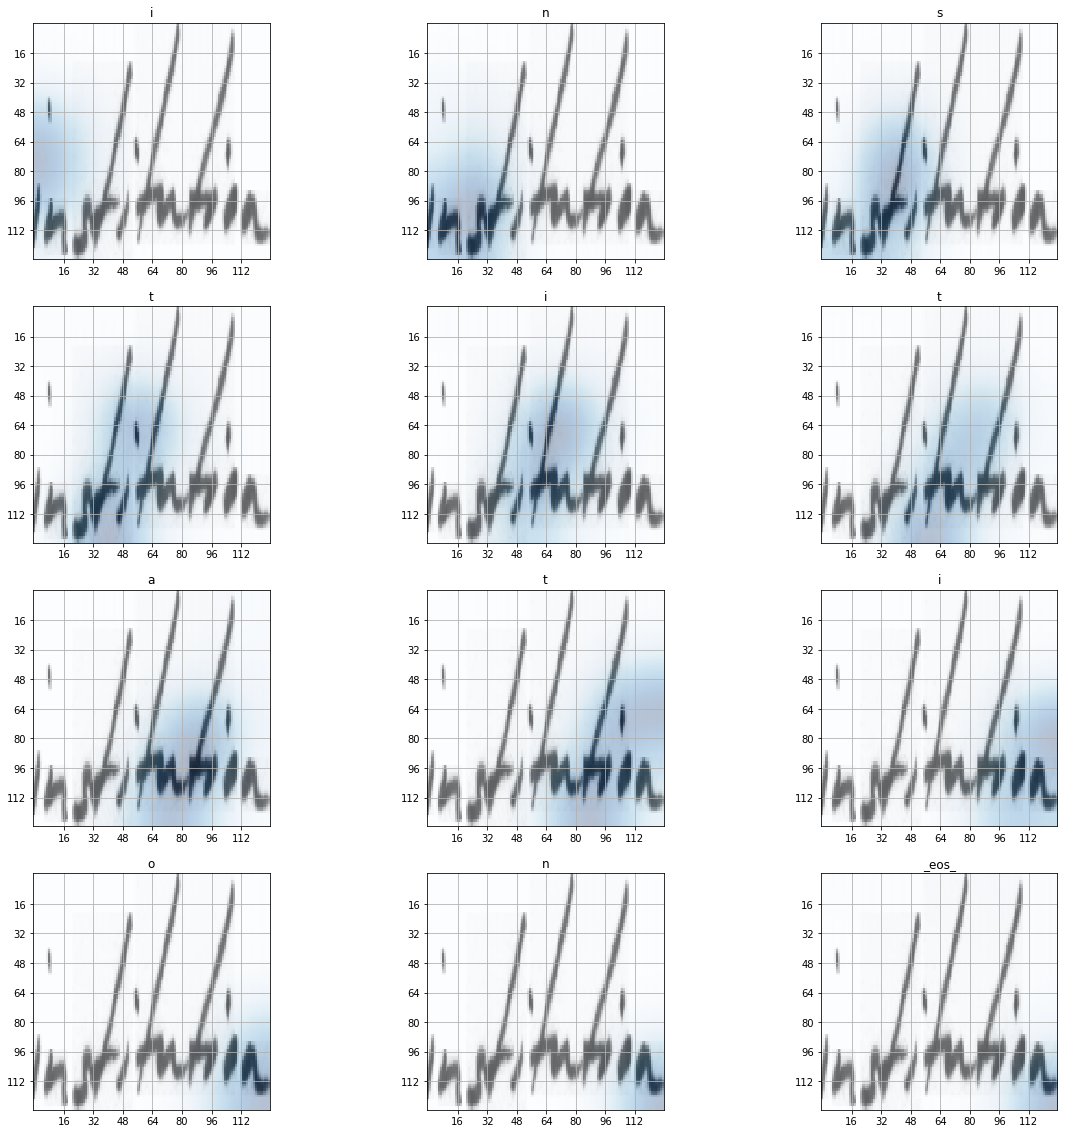

In [78]:
fig, axes = plt.subplots(4, 3, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    a = g_filter(img_attns[i])
    ax.imshow(img, alpha=None)
    ax.imshow(a, cmap='Blues', interpolation='nearest', alpha=0.3)
    
    # Attention
    ticks = np.arange(16, sz, 16)
    ax.set_yticks(ticks, minor=False)
    ax.set_xticks(ticks, minor=False)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)

    ax.set_title(itos[pred[i].item()])

# Beam Search

In [48]:
preds.shape   #(sl, bs, chars)

torch.Size([20, 50, 82])

In [81]:
prob = preds[:, idx]
amts, idxs = torch.topk(prob[6], 5)
amts, idxs

(tensor([5.6389, 5.3988, 4.1479, 3.6222, 2.6819],
        device='cuda:0', grad_fn=<TopkBackward>),
 tensor([56, 75, 76, 69, 60], device='cuda:0'))

In [82]:
[itos[i] for i in idxs]

['a', 't', 'u', 'n', 'e']